Helper

In [ ]:
import re
from pathlib import Path
import yaml

def get_metadata(metaname):
  """
  Parameters
  ----------
  metaname: str
    metaname consists of rat number, study day, condition, treatment value and trial number
    each separated by underscore.
    Example: Rat2_SD4_HC_2_posttrial1

  Returns
  -------
  metadata: dict
   Dictionary object which contains each conditions.
  """
  metadata = {}

  metaname  = metaname.split('_')
  metadata["rat_id"]    = int(metaname[0][3:])
  metadata["study_day"] = int(metaname[1][2:])
  metadata["condition"] = metaname[2]
  metadata["treatment"] = int(metaname[3])
  metadata["trial_num"] = metaname[4][9:]

  return metadata

def create_title(metadata):
    treatment = {0: "Negative CBD", 1: "Positive CBD",
                 2: "Negative RGS14", 3:"Positive RGS14", 4:"OS basic"}

    title = "Rat " + str(metadata["rat_id"])
    title += " Study Day: " + str(metadata["study_day"])
    title += " Treatment: " + treatment[metadata["treatment"]]
    title += " Post-trial: " + str(metadata["trial_num"])
    return title

def create_name_cbd(file, overview_df):
    #pattern for matching the information on the rat
    pattern = r'Rat(\d+)_.*_SD(\d+)_([A-Z]+).*posttrial(\d+)'

    # extract the information from the file path
    match = re.search(pattern, file)
    rat_num = int(match.group(1))
    sd_num = int(match.group(2))
    condition = str(match.group(3))
    posttrial_num = int(match.group(4))

    mask = (overview_df['Rat no.'] == rat_num) & (overview_df['Study Day'] == sd_num) & (overview_df['Condition'] == condition)

    # use boolean indexing to extract the Treatment value
    treatment_value = overview_df.loc[mask, 'Treatment'].values[0]

    # Extract the value from the "treatment" column of the matching row
    if treatment_value == 0:
        treatment = '0'
    else:
        treatment = '1'

    title_name = 'Rat' + str(rat_num) +'_' + 'SD' + str(sd_num) + '_' + condition + '_' + treatment + '_' + 'posttrial' + str(posttrial_num)
    #RatID,StudyDay,condition,conditionfull, treatment, treatmentfull, posstrial number

    return title_name

def create_name_rgs(fname):
    #pattern for matching the information on the rat
    pattern = r'Rat(\d+)_.*_SD(\d+)_([A-Z]+).*post[\w-]+trial(\d+)'

    # extract the information from the file path
    match = re.search(pattern, fname, flags=re.IGNORECASE)
    rat_num = int(match.group(1))
    sd_num = int(match.group(2))
    condition = str(match.group(3))
    posttrial_num = int(match.group(4))

    # Extract the value from the "treatment" column of the matching row
    if (rat_num == 1) or (rat_num == 2) or (rat_num == 6) or (rat_num == 9) :
        treatment = '2'
    else:
        treatment = '3'

    title_name = 'Rat' + str(rat_num) +'_' + 'SD' + str(sd_num) + '_' + condition + '_' + treatment + '_' + 'posttrial' + str(posttrial_num)
    #RatID,StudyDay,condition,conditionfull, treatment, treatmentfull, posstrial number

    return title_name

def create_name_os(hpc_fname):
    metadata = str(Path(hpc_fname).parent.parent.name).split("_")
    title = metadata[1] + "_" + metadata[2] + "_" + metadata[3]

    pattern = r"post_trial(\d+)"
    match = re.search(pattern, hpc_fname, re.IGNORECASE)
    title += "_4_" + "posttrial" + match.group(1)

    #RatID,StudyDay,condition,conditionfull, treatment, treatmentfull, posstrial number
    return title

def partition_to_4(rem_dict):
    # rem_dict: dictionary with keys as tuples and values as numpy arrays
    keys = sorted(rem_dict.keys())
    partitions = [{} for _ in range(4)]  # Create a list of 4 empty dictionaries

    for rem_idx in keys:
        _, end = rem_idx
        if end < 2700:  # First region
            partitions[0][rem_idx] = rem_dict[rem_idx]
        elif end < 5400:  # Second region
            partitions[1][rem_idx] = rem_dict[rem_idx]
        elif end < 8100:  # Third region
            partitions[2][rem_idx] = rem_dict[rem_idx]
        else:  # Fourth region
            partitions[3][rem_idx] = rem_dict[rem_idx]

    return partitions

def load_config(yaml_file):
    with open(yaml_file, 'r') as file:
        config = yaml.safe_load(file)
    return config

Dataset Loader

In [ ]:
import os
import re
import logging
import pandas as pd
from pathlib import Path
from tabulate import tabulate
from fooof import FOOOF
from neurodsp.spectral import compute_spectrum
from scipy.io import loadmat
import numpy as np
import yaml
from scipy.signal import decimate
from scipy.signal import butter, filtfilt

# Normalize the LFP signal
def normalizer(x):
    return (x - np.nanmean(x)) / (np.nanstd(x))
#from helper import load_config

logger = logging.getLogger("runtime")

class DatasetLoader:
    def __init__(self, CONFIG_DIR):
        """
        Initialize the DatasetLoader with dataset arguments and configuration directory.

        Args:
            CONFIG_DIR: Path to the YAML configuration file.
            {'dataset_name' : {'path' : '/path/to/dataset', ...}
        """
        self.config = load_config(CONFIG_DIR)
        self.combined_mapped = {}

        # name_func(HPC_filename) ->
        #cbd_wrapper = decorate_cbd(cbd_name_func=create_name_cbd, CBD_DIR=self.config['CBD']['path'])
        #self.naming_functions = {"CBD": cbd_wrapper, "RGS": create_name_rgs, "OS": create_name_os}

        self.naming_functions = {"RGS": create_name_rgs, "OS": create_name_os}


    def load_datasets(self):
        """
        Load datasets.

        Args:
            dataset_args: Dictionary containing dataset arguments.
        Returns:
            Combined mapping of dataset files.
            {name : (sleep_states_fname, hpc_fname, pfc_fname),
            name : (sleep_states_fname, hpc_fname, pfc_fname),
            ...}
        """
        for name, info in self.config.items():
            logger.debug(f"STARTED: Loading the dataset {name}.")
            dataset_dir = info['path']
            name_func = self.naming_functions[name]

            for root, dirs, _ in os.walk(dataset_dir):
                mapped = process_directory(root, dirs, info, name_func)
                self.combined_mapped.update(mapped)

            logger.debug(f"FINISHED: Loading the dataset {name}.")
            logger.debug(f"Number of files {len(self.combined_mapped)}.")

        return self.combined_mapped

    def __getitem__(self, key):
        return self.combined_mapped[key]

    def __iter__(self):
        return iter(self.combined_mapped)

    def __len__(self):
        return len(self.combined_mapped)

    def __str__(self):
        return f"Total loaded recordings: {len(self.combined_mapped)}"


def process_directory(root, dirs, patterns, name_func):
    """
    Process a directory to map sleep states and HPC files using specified patterns and naming function.

    Args:
        root: Root directory path.
        dirs: List of directories.
        patterns: Dictionary containing regex patterns for matching files.
        name_func: Function to generate a name based on the HPC filename.

    Returns:
        mapped: Dictionary mapping generated names to sleep states and HPC files.
    """
    mapped = {}
    posttrial_pattern = patterns["posttrial"]
    hpc_pattern = patterns["hpc"]
    pfc_pattern = patterns["pfc"]
    states_pattern = patterns["states"]

    for dir in dirs:
        if dir.startswith('.'):
            continue
        #logger.debug(f"Dir: {dir}")
        if re.match(posttrial_pattern, dir, flags=re.IGNORECASE):
            dir_path = Path(root) / dir
        #    logger.debug(f"MATCH: {dir_path}")
            try:
                hpc_file = str(next(dir_path.glob(hpc_pattern)))
                pfc_file = str(next(dir_path.glob(pfc_pattern)))
                states_file = str(next(dir_path.glob(states_pattern)))
                name = name_func(hpc_file)
        #        logger.debug(f"{name}:({states_file}, {hpc_file})")
                mapped[name] = (states_file, hpc_file, pfc_file)
            except StopIteration:
                logger.warning(f"Expected files not found in directory: {dir_path}")
            except Exception as e:
                logger.error(f"Error processing directory {dir_path}: {e}")
        #else:
        #    logger.debug(f"MISMATCH: {Path(root) / dir}")
    return mapped

def decorate_cbd(cbd_name_func, CBD_DIR):
    """
    Decorator function to load the CBD overview file and wrap the CBD naming function.
    """
    try:
        path_to_overview = Path(CBD_DIR) / "overview.csv"
        overview_df = pd.read_csv(path_to_overview)
    except Exception as e:
        raise ValueError(f"Failed to load CBD overview file. {e}")

    def wrapper(file):
        return cbd_name_func(file, overview_df=overview_df)

    return wrapper

def create_name_cbd(file, overview_df):
    """
    Create a name for the CBD dataset based on the HPC filename and overview DataFrame.

    Args:
        file: HPC filename.
        overview_df: Overview DataFrame containing metadata.
    Returns:
        Generated name.
    """
    pattern = r'Rat(\d+)_.*_SD(\d+)_([A-Z]+).*posttrial(\d+)'
    match = re.search(pattern, file)

    if not match:
        raise ValueError(f"Filename {file} does not match the expected pattern.")

    rat_num = int(match.group(1))
    sd_num = int(match.group(2))
    condition = str(match.group(3))
    posttrial_num = int(match.group(4))

    mask = (overview_df['Rat no.'] == rat_num) & (overview_df['Study Day'] == sd_num) & (overview_df['Condition'] == condition)

    if not any(mask):
        raise ValueError(f"No matching record found for Rat {rat_num}, SD {sd_num}, Condition {condition}.")

    treatment_value = overview_df.loc[mask, 'Treatment'].values[0]

    treatment = '1' if treatment_value != 0 else '0'

    return f'Rat{rat_num}_SD{sd_num}_{condition}_{treatment}_posttrial{posttrial_num}'

def create_name_rgs(fname):
    """
    Create a name for the RGS dataset based on the HPC filename.
    """
    pattern = r'Rat(\d+)_.*_SD(\d+)_([A-Z]+).*post[\w-]+trial(\d+)'
    match = re.search(pattern, fname, flags=re.IGNORECASE)

    if not match:
        raise ValueError(f"Filename {fname} does not match the expected pattern.")

    rat_num = int(match.group(1))
    sd_num = int(match.group(2))
    condition = str(match.group(3))
    posttrial_num = int(match.group(4))

    treatment = '2' if rat_num in [1, 2, 6, 9] else '3'

    return f'Rat{rat_num}_SD{sd_num}_{condition}_{treatment}_posttrial{posttrial_num}'

def create_name_os(hpc_fname):
    """
    Create a name for the OS dataset based on the HPC filename.
    """

    metadata = str(Path(hpc_fname).parent.parent.name).split("_")

    if len(metadata) < 4:
        raise ValueError(f"Filename {hpc_fname} does not contain enough metadata.")

    title = f"{metadata[1]}_{metadata[2]}_{metadata[3]}"

    pattern = r"post_trial(\d+)"
    match = re.search(pattern, hpc_fname, re.IGNORECASE)

    if not match:
        raise ValueError(f"Filename {hpc_fname} does not match the expected pattern.")

    title += f"_4_posttrial{match.group(1)}"

    return title


ModuleNotFoundError: No module named 'fooof'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Table

In [ ]:
!pip install tabulate
import sys
import pandas as pd
from tabulate import tabulate

CONFIG_DIR = "/content/drive/MyDrive/RGS14/data/dataset_loading.yaml" #change this to your local path

datasets = DatasetLoader(CONFIG_DIR)
mapped_datasets = datasets.load_datasets()

#print(mapped_datasets.keys())

"""for name in mapped_datasets.keys():
    print(name)
    states_fname, hpc_fname, pfc_fname = mapped_datasets[name]
    print(states_fname)
    print(hpc_fname)

for name in mapped_datasets.keys():
    metadata = get_metadata(name)
    print(metadata)
"""



metadata_list = []
for name in mapped_datasets.keys():
    metadata = get_metadata(name)
    metadata['dataset_name'] = name
    metadata_list.append(metadata)

# Converting metadata to DataFrame for a tabular format
metadata_df = pd.DataFrame(metadata_list)

# Display the DataFrame with full table and lines around each cell
print(tabulate(metadata_df, headers='keys', tablefmt='grid'))

NameError: name 'DatasetLoader' is not defined

In [ ]:
# Install necessary packages
!pip install neurodsp
!pip install fooof
!pip install scipy
!pip install matplotlib
!pip install --upgrade fooof

# NeuroDSP
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

 FOOOF
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from fooof.utils.download import load_fooof_data
from fooof.sim.gen import gen_aperiodic
from fooof.plts.annotate import plot_annotated_peak_search

# Other
import copy
import scipy
from scipy.io import loadmat
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import mode
from scipy.io import loadmat
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import requests
from io import BytesIO
from pathlib import Path
from tabulate import tabulate
from fooof import FOOOF
from neurodsp.spectral import compute_spectrum
from scipy.io import loadmat
import numpy as np
import yaml
from scipy.signal import decimate

In [ ]:
import re
import os
import logging
import pandas as pd
from pathlib import Path
from tabulate import tabulate
from fooof import FOOOF
from neurodsp.spectral import compute_spectrum
from scipy.io import loadmat
import numpy as np
import yaml
from scipy.signal import decimate
from scipy.signal import butter, filtfilt

# Set up logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Load configuration from YAML file
def load_config(yaml_file):
    with open(yaml_file, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Function to extract metadata from file names
def get_metadata(metaname):
    metadata = {}
    metaname = metaname.split('_')
    metadata["rat_id"] = int(metaname[0][3:])
    metadata["study_day"] = int(metaname[1][2:])
    metadata["condition"] = metaname[2]
    metadata["treatment"] = int(metaname[3])
    metadata["trial_num"] = metaname[4][9:]
    return metadata

# Bandpass filter the data to remove unwanted frequencies
def bandpass_filter(data, fs, lowcut=1.0, highcut=50.0, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Ensure the cutoff frequencies are within valid range
    if low <= 0 or high >= 1:
        high = min(high, 0.99)  # Adjust highcut if it exceeds the Nyquist limit
        logger.warning(f"Adjusted highcut frequency to be within valid range: highcut={high * nyquist}")

    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Calculate the slope using FOOOF for each dataset
def calculate_slope(lfp_data, fs):
    # Optionally downsample the data if too large
    if len(lfp_data) > 100000:
        logger.debug("Downsampling LFP data...")
        lfp_data = decimate(lfp_data, 10)
        fs = fs / 10

    # Apply bandpass filter to standardize the frequency content
    try:
        logger.debug("Applying bandpass filter to LFP data...")
        lfp_data = bandpass_filter(lfp_data, fs)
    except ValueError as e:
        logger.error(f"Bandpass filter error: {e}")
        raise

    # Compute the power spectrum using Welch's method
    logger.debug("Computing power spectrum...")
    #freq_mean, psd_mean = compute_spectrum(lfp_data, fs, method='welch', avg_type='mean')
    freq_mean, psd_mean = compute_spectrum(lfpHPC_sig, fs, method='welch', avg_type='mean', nperseg=3000)

    # Remove frequency == 0 to avoid fitting issues
    freq_mean = freq_mean[freq_mean > 0]
    psd_mean = psd_mean[1:]

    # Set lower bound for peak width to be 2x the frequency resolution
    freq_resolution = freq_mean[1] - freq_mean[0]
    peak_width_lower = max(2 * freq_resolution, 0.5)  # Ensure a reasonable lower bound

    # Fit the power spectrum using FOOOF, with a limit on iterations and a specific frequency range
    logger.debug("Fitting power spectrum using FOOOF...")
    fm = FOOOF(peak_width_limits=[peak_width_lower, 12.0], max_n_peaks=6, aperiodic_mode='fixed')
    fm.fit(freq_mean, psd_mean, [1, 50])  # Limit fitting to 1-50 Hz
    fm.plot(plot_peaks='shade', plot_aperiodic=True, title=f'Power spectrum of the REM segment for frequency range: 1-50')

    aperiodic_params = fm.get_params('aperiodic_params')

    # Return the slope (first element of aperiodic parameters)
    return aperiodic_params[0]

# DatasetLoader class to handle datasets
class DatasetLoader:
    def __init__(self, CONFIG_DIR):
        self.config = load_config(CONFIG_DIR)
        self.combined_mapped = {}
        self.naming_functions = {"RGS": create_name_rgs, "OS": create_name_os}

    def load_datasets(self):
        for name, info in self.config.items():
            dataset_dir = info['path']
            name_func = self.naming_functions[name]
            for root, dirs, files in os.walk(dataset_dir):
                logger.debug(f"Processing directory: {root}")
                logger.debug(f"Directories: {dirs}")
                logger.debug(f"Files: {files}")
                mapped = process_directory(root, dirs, files, info, name_func)
                self.combined_mapped.update(mapped)
        return self.combined_mapped

# Process directory to map sleep states and HPC files
def process_directory(root, dirs, files, patterns, name_func):
    mapped = {}
    posttrial_pattern = patterns["posttrial"]
    hpc_pattern = patterns["hpc"]
    states_pattern = patterns["states"]

    # Log all files in the current directory for debugging purposes
    logger.debug(f"Listing all files in directory {root}: {files}")

    for dir in dirs:
        if dir.startswith('.'):  # Skip hidden directories
            continue
        if re.match(posttrial_pattern, dir, flags=re.IGNORECASE):
            dir_path = Path(root) / dir
            try:
                logger.debug(f"Attempting to match files in directory: {dir_path}")
                hpc_file = str(next(dir_path.glob(hpc_pattern)))
                states_file = str(next(dir_path.glob(states_pattern)))
                name = name_func(hpc_file)
                mapped[name] = (states_file, hpc_file)
            except StopIteration:
                logger.warning(f"Expected files not found in directory: {dir_path}. Patterns used: hpc='{hpc_pattern}', states='{states_pattern}'")
            except Exception as e:
                logger.error(f"Error processing directory {dir_path}: {e}")
    return mapped

# Load data from the specified file path
def load_lfp_data(file_path):
    try:
        data = loadmat(file_path)
        return np.squeeze(data['HPC'])
    except KeyError:
        logger.error(f"Key 'HPC' not found in the file: {file_path}")
        return None
    except Exception as e:
        logger.error(f"Error loading LFP data from {file_path}: {e}")
        return None

# Configuration directory (replace with your local path)
CONFIG_DIR = "/content/drive/MyDrive/RGS14/data/dataset_loading.yaml"

# Load datasets
datasets = DatasetLoader(CONFIG_DIR)
logger.debug("Loading datasets...")
mapped_datasets = datasets.load_datasets()

metadata_list = []
for name in mapped_datasets.keys():
    states_fname, hpc_fname = mapped_datasets[name]
    metadata = get_metadata(name)

      # Load LFP data and calculate the slope
    lfp_data = load_lfp_data(hpc_fname)
    if lfp_data is None:
        continue
    ##########
    # Normalize and flatten data
    lfpHPC_normalized = normalizer(lfp_data)
    lfpHPC_sig = np.ravel(lfpHPC_normalized)
    ##########

  # Normalize and flatten data
    lfpHPC_normalized = normalizer(lfp_data)
    lfpHPC_sig = np.ravel(lfpHPC_normalized)

    fs = 1000  # Assuming the sampling rate is 1000 Hz (adjust as needed)
    try:
        slope = calculate_slope(lfp_data, fs)
    except Exception as e:
        logger.error(f"Error calculating slope for {name}: {e}")
        continue

    # Add the slope to metadata
    metadata['slope'] = slope
    metadata['dataset_name'] = name
    metadata_list.append(metadata)

# Convert metadata to DataFrame for tabular format
metadata_df = pd.DataFrame(metadata_list)

# Display the DataFrame with full table and lines around each cell
print(tabulate(metadata_df, headers='keys', tablefmt='grid'))


ModuleNotFoundError: No module named 'fooof'

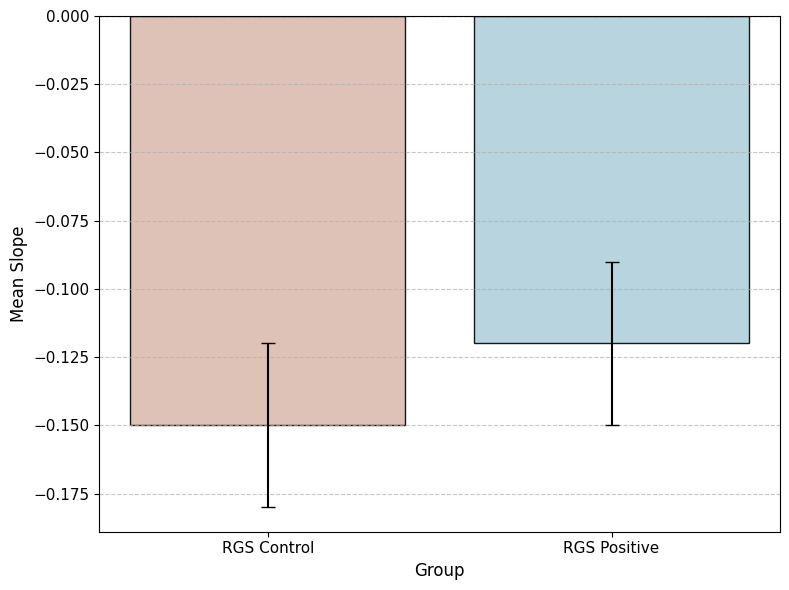

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for RGS Control and RGS Positive groups
groups = ['RGS Control', 'RGS Positive']
mean_slopes = [-0.15, -0.12]  # Mean slopes
sem_values = [0.03, 0.03]     # Standard error of the mean (SEM)

# Define faded colors for bars
colors = ['#dbbcb1', '#b1d0db']  # Faded green and orange

# Bar chart with error bars
plt.figure(figsize=(8, 6))
plt.bar(groups, mean_slopes, yerr=sem_values, capsize=5, color=colors, alpha=0.9, edgecolor='black')

# Add gridlines for easier readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels and title
plt.ylabel('Mean Slope', fontsize=12)
plt.xlabel('Group', fontsize=12)
#plt.title('Figure 1: Mean Slope Comparison between RGS Control and RGS Positive Groups', fontsize=14)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Reference line at 0

# Customize the plot
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Show the plot
plt.show()



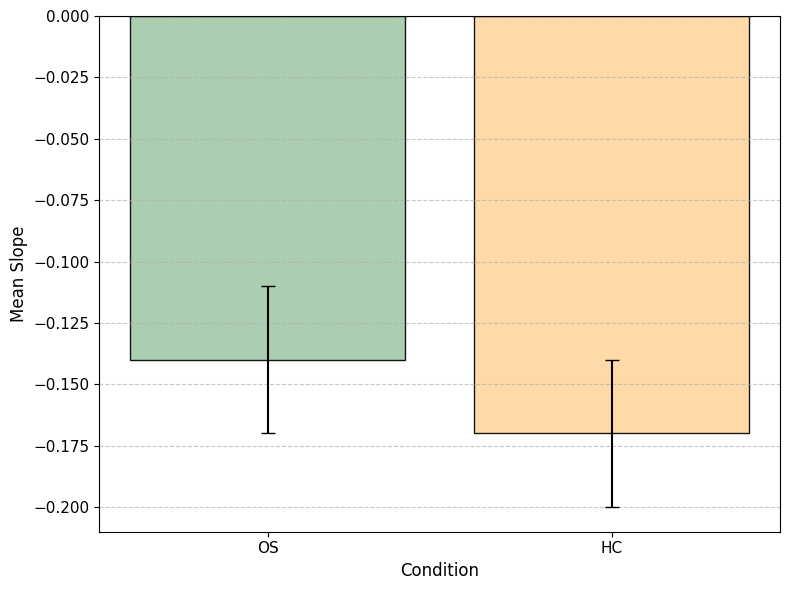

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for OS and HC conditions
conditions = ['OS', 'HC']
mean_slopes = [-0.14, -0.17]  # Mean slopes
sem_values = [0.03, 0.03]     # Standard error of the mean (SEM)

# Define faded colors for bars
colors = ['#A3C9A8', '#FFD59E']  # Faded green and orange

# Bar chart with error bars
plt.figure(figsize=(8, 6))
plt.bar(conditions, mean_slopes, yerr=sem_values, capsize=5, color=colors, alpha=0.9, edgecolor='black')

# Add gridlines for easier readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels and title
plt.ylabel('Mean Slope', fontsize=12)
plt.xlabel('Condition', fontsize=12)
#plt.title('Figure 2: Mean Slope Comparison between OS and HC Conditions', fontsize=14)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Reference line at 0

# Customize the plot
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Show the plot
plt.show()
